# Метрики

## Imports

In [ ]:
!pip install rectools

In [2]:
import pandas as pd
import numpy as np
import numba as nb
import requests
from rectools import Columns

from tqdm.auto import tqdm

In [3]:
np.random.seed(23)

## Read data

In [4]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [5]:
!unzip kion.zip

Archive:  kion.zip
   creating: data_original/
  inflating: data_original/interactions.csv  
  inflating: __MACOSX/data_original/._interactions.csv  
  inflating: data_original/users.csv  
  inflating: __MACOSX/data_original/._users.csv  
  inflating: data_original/items.csv  
  inflating: __MACOSX/data_original/._items.csv  


In [6]:
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [7]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [8]:
top_k = 10
df, users, recs = generate_subsample(10000, top_k)
target = df.values

In [10]:
def mrr_naive(target, users, recs, k):
    rates = []
    for i, user in enumerate(users):
        user_target = target[target[:, 0] == user][:, 1]
        rec_in_target = False
        min_rate = k + 1
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                min_rate = j + 1
                rec_in_target = True
                break
        if rec_in_target:
          rates.append(1 / min_rate)
        else:
          rates.append(0)
    return sum(rates) / len(users)

In [11]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs, k):
    rates = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        min_rate = k + 1
        rec_in_target = False
        for j in range(len(recs[i])):
            if recs[i][j] in user_target:
                min_rate = j + 1
                rec_in_target = True
                break
        if rec_in_target:
          rates[i] = (1 / min_rate)
    return rates.mean()

In [12]:
def mrr_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
      Columns.User: np.repeat(users, top_k),
      Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    return (1.0 / df_recs.groupby(Columns.User)[Columns.Rank].apply(min)).sum() / len(users)

In [13]:
%timeit mrr_naive(target, users, recs, top_k)

2.03 s ± 39.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit mrr_numba(target, users, recs, top_k)

1.11 s ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit mrr_pandas(df, users, recs, top_k) 

1.01 s ± 31.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
print(mrr_naive(target, users, recs, top_k), mrr_numba(target, users, recs, top_k), mrr_pandas(df, users, recs, top_k))

0.07836801587301619 0.07836801587301577 0.07836801587301587


In [ ]:
results = []
for top_k in [10, 50, 100]:
  for user_count in [100, 1000, 10000, 100000]:
    df, users, recs = generate_subsample(user_count, top_k)
    target = df.values
    naive = %timeit -o mrr_naive(target, users, recs, top_k)
    numba = %timeit -o mrr_numba(target, users, recs, top_k)
    pandas = %timeit -o mrr_pandas(df, users, recs, top_k)
    results.append([naive.average, numba.average, pandas.average])

3.17 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
112 µs ± 755 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
12.3 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52.5 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.3 ms ± 97.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
90.5 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.3 s ± 5.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
898 ms ± 6.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
952 ms ± 77.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 42s ± 823 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 29s ± 696 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.26 s ± 257 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.4 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
157 µs ± 50.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
12.4 ms ± 354 µs per l

In [ ]:
print(results)

[[0.0031689096114283595, 0.00011154044512857127, 0.012250429870000029], [0.05251929265714352, 0.009299242138571345, 0.09046094810000146], [1.301709081714291, 0.8984132230000016, 0.9516514150000148], [102.49592083042856, 89.4815973899999, 9.263679754428397], [0.011439878968571975, 0.0001567242491428715, 0.012444297498572527], [0.11967227374285097, 0.009083996980000718, 0.09103779407142351], [2.0857187010000677, 0.8869353767141936, 0.9628759572856974], [108.3837689724285, 88.923429762, 10.012739046285658], [0.013833741909998674, 0.00010763156232855441, 0.012537246242860161], [0.1785312022857397, 0.00940299005428512, 0.0926682194285604], [2.5347517454284962, 0.886695998000245, 1.0482716102858052], [112.64749864414287, 88.53726327957156, 11.576991121571544]]


In [22]:
results = np.array([[0.0031689096114283595, 0.00011154044512857127, 0.012250429870000029], [0.05251929265714352, 0.009299242138571345, 0.09046094810000146], [1.301709081714291, 0.8984132230000016, 0.9516514150000148], [102.49592083042856, 89.4815973899999, 9.263679754428397], [0.011439878968571975, 0.0001567242491428715, 0.012444297498572527], [0.11967227374285097, 0.009083996980000718, 0.09103779407142351], [2.0857187010000677, 0.8869353767141936, 0.9628759572856974], [108.3837689724285, 88.923429762, 10.012739046285658], [0.013833741909998674, 0.00010763156232855441, 0.012537246242860161], [0.1785312022857397, 0.00940299005428512, 0.0926682194285604], [2.5347517454284962, 0.886695998000245, 1.0482716102858052], [112.64749864414287, 88.53726327957156, 11.576991121571544]])

In [28]:
results[0]

array([0.00316891, 0.00011154, 0.01225043])

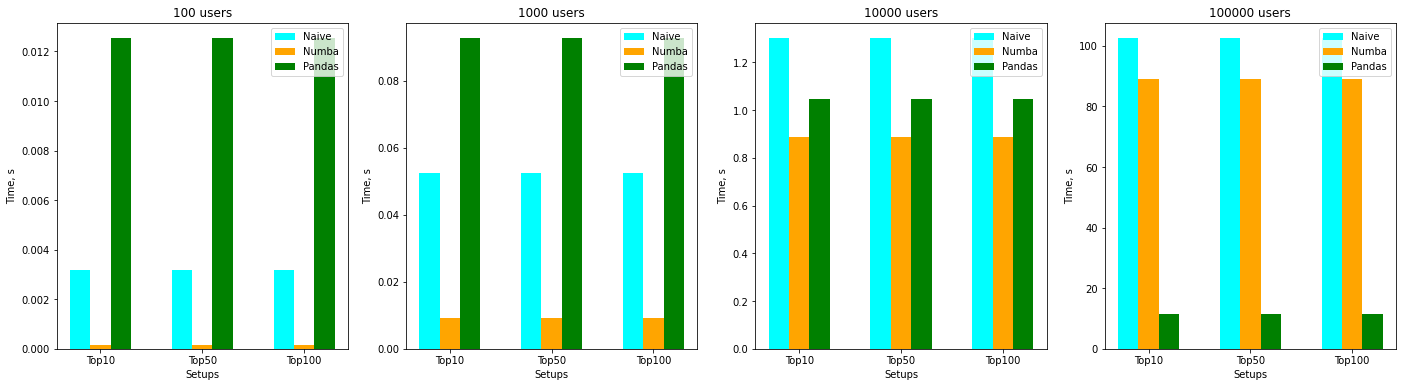

In [60]:
import matplotlib.pyplot as plt
import numpy as np
  
# create data
top_array = [10, 50, 100]
user_count_array = [100, 1000, 10000, 100000]
fig, ax = plt.subplots(1,4, figsize=(24,6))
for i in range(4):
  x = np.arange(3)
  y1 = results[i,0]
  y2 = results[i+4,1]
  y3 = results[i+8,2]
  width = 0.2
    
  # plot data in grouped manner of bar type
  ax[i].bar(x-0.2, y1, width, color='cyan')
  ax[i].bar(x, y2, width, color='orange')
  ax[i].bar(x+0.2, y3, width, color='green')
  ax[i].set_xlabel("Setups")
  ax[i].set_ylabel("Time, s")
  ax[i].legend(["Naive", "Numba", "Pandas"])
  ax[i].set_title(f"{user_count_array[i]} users")
plt.setp(ax, xticks=x, xticklabels=['Top10', 'Top50', 'Top100'])
plt.show()

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)


In [ ]:
import pandas as pd
import numpy as np

# считываем данные
qid_query = pd.read_csv("/content/drive/MyDrive/recsys_lecture2/yacup/qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv("/content/drive/MyDrive/recsys_lecture2/yacup/qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv("/content/drive/MyDrive/recsys_lecture2/yacup/hostid_url.tsv", sep="\t", names=["hostid", "url"])

# делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")


def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)


def pfound_vector(group):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
    top10_np = top10.to_numpy() 
    pbreak = np.power(np.repeat(1 - 0.15, 10), np.arange(10))
    pRel_ = np.roll(1 - top10_np, 1)
    pRel_[0] = 1
    pRel_ = pRel_.cumprod() 
    return np.sum(pRel_ * pbreak * top10_np)

def pfound(group):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    for ind, val in enumerate(top10):
        pfound += val*plook(ind, top10.values)
    return pfound


qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound) # группируем по qid и вычисляем pfound
qid_pfound_vector = qid_url_rating_hostid.groupby('qid').apply(pfound_vector) # группируем по qid и вычисляем pfound векторизованный
print(qid_pfound.mean(), qid_pfound_vector.mean())